Задача Титаника одна из самых известных платформы Kaggle. Рано или поздно, любой начинающий специалист по данным возьмется за ее решение. Здесь я покажу на пальцах: как проверить гипотезы, найти зависимости и реализовать предсказание только на основе аналитики.

## Описание задачи

Всем знакома история, связанная с этим кораблем. Посмотрели одноименную картину и имеем представление о чем пойдет речь.

На борту находилось 2200 человек, после крушения выжило ( по некоторым данным) 565=( Предполагается, что у кого-то на борту шансов выжить было больше. Может если это был мужчина, или богач из первого класса... Мы изучим различные гипотезы, проверим их с помощью математической статистики и смоделируем свой вектор предсказания выживания на судне, а потом сравним с тем, как отработают знаменитые алгоритмы.

## Обработка данных
Прежде чем начать обработку, необходимо эти данные получить. Любой желающий может зарегистрироваться на Kaggle и принять участие в соревновании. Для удобства прилагаю ссылку, после регистрации нажмите кнопку "Принять участие" и скачет два файла gender_submission.csv, train.csv и test.csv. Для начала импортируем необходимые библиотеки.

Обзор
Данные были разделены на две группы:

обучающий набор (train.csv)
тестовый набор (test.csv)
Обучающий набор следует использовать для построения ваших моделей машинного обучения. Для обучающего набора мы предоставляем результат (также известный как “основная правда”) для каждого пассажира. Ваша модель будет основана на “характеристиках”’ таких как пол и класс пассажиров. Вы также можете использовать проектирование объектов для создания новых объектов.

Тестовый набор следует использовать, чтобы увидеть, насколько хорошо ваша модель работает с невидимыми данными. Для тестового набора мы не предоставляем полную информацию для каждого пассажира. Ваша задача - предсказать эти результаты. Для каждого пассажира в тестовом наборе используйте модель, которую вы обучили, чтобы предсказать, выжили ли они после крушения "Титаника".

Мы также включаем gender_submission.csv, набор прогнозов, которые предполагают, что выживут только пассажиры женского пола, в качестве примера того, как должен выглядеть файл отправки.

In [2]:
import pandas as pd
import numpy as np 
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import mannwhitneyu 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
df = pd.read_csv('C:\\Users\\lizgn\\Downloads\\gender_submission.csv') 
test = pd.read_csv('C:\\Users\\lizgn\\Downloads\\test.csv') 
train = pd.read_csv('C:\\Users\\lizgn\\Downloads\\train.csv')

<AxesSubplot:>

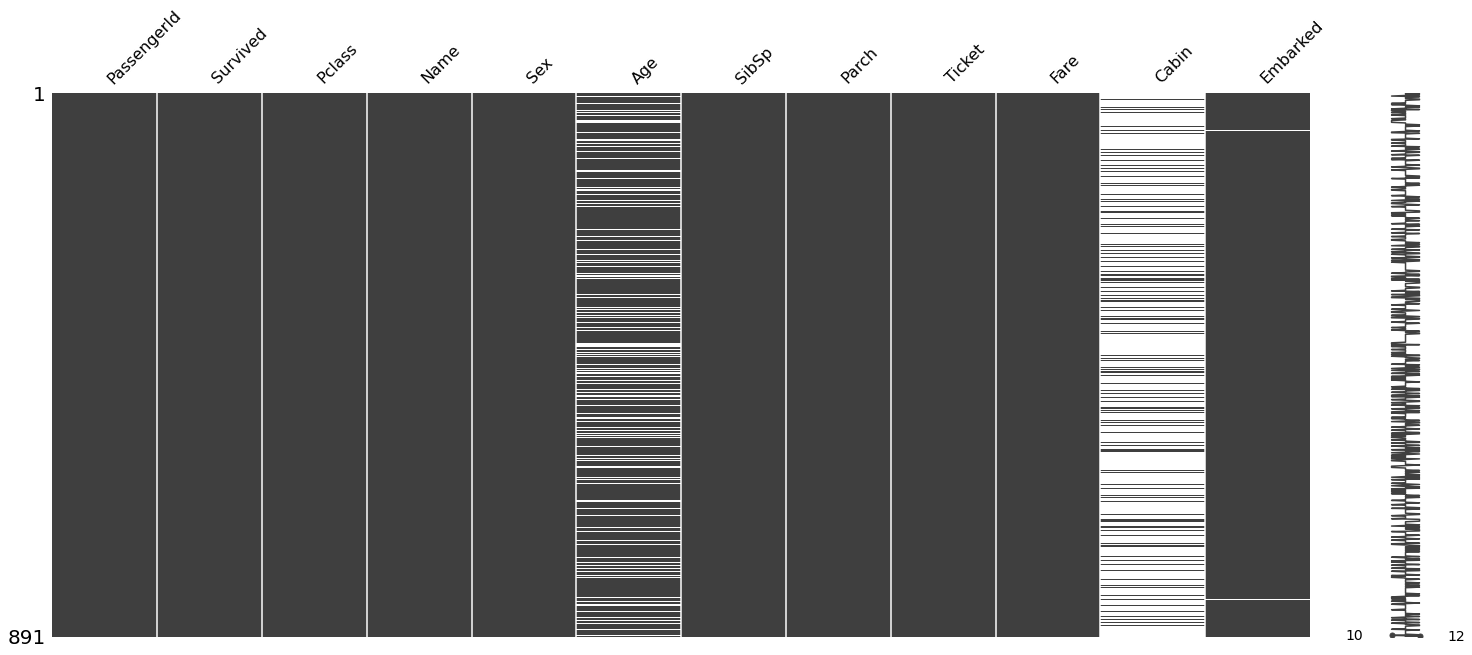

In [4]:
msno.matrix(train)

<AxesSubplot:>

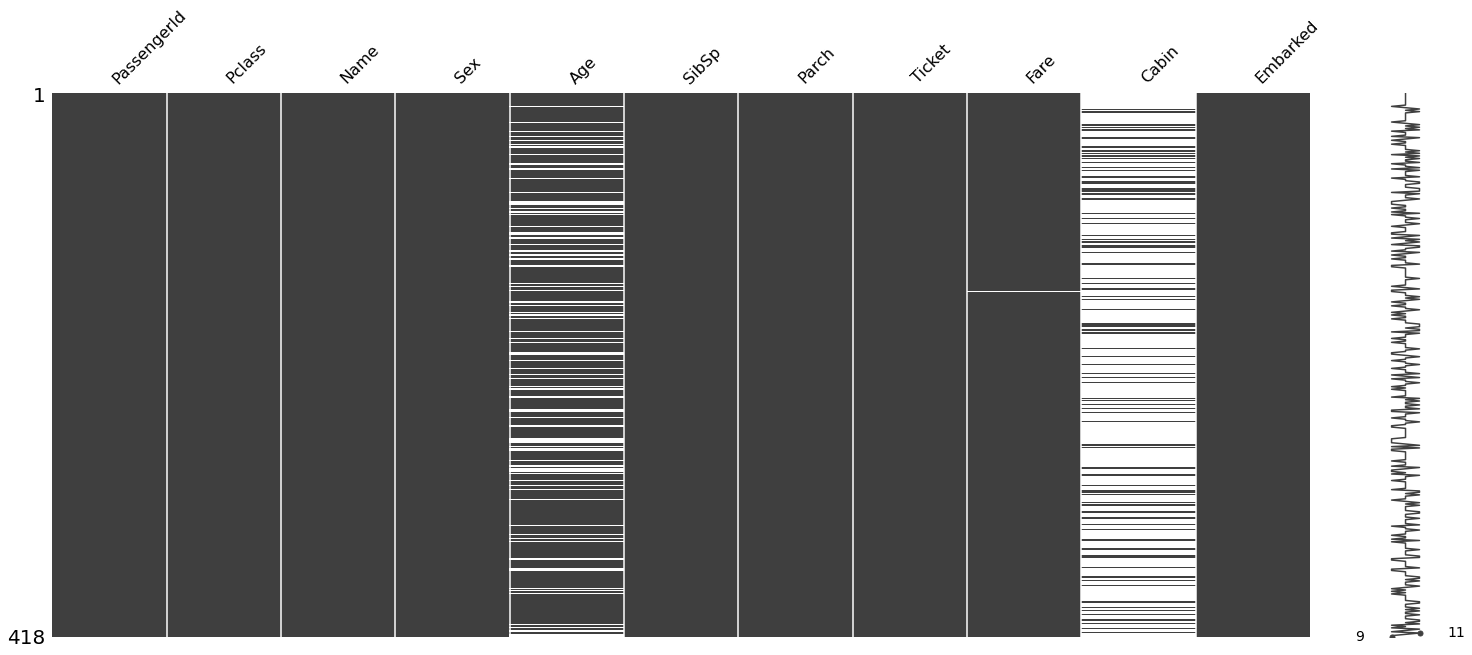

In [5]:
msno.matrix(test)

Из указанного выше следует, что в train и test содержатся несовпадающий столбцы ( их названия по оси x) в train - 891 наблюдение, в test- 418. В обоих датасетах много пропущенных значений в столбцах Age и Cabin. df содержит 418 наблюдений с номером пассажира и предсказанием Survived в котором 1- спасен, 0 нет. В нем также 418 значений выживания для пассажиров из test. 

Для изучения данных соединим train и test. (В правду добавляем тестовый набор с невидимыми данными и гипотезу, что должны выжить пассажиры только женского пола)

In [6]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
y = pd.merge(test, df, how='right')
#или
#y=pd.merge(df,test, on='PassengerId', how='right')
#или
#y=pd.merge(df,test)
#Если в присоединяемом столбце не отображаются значения, значит, происходит чтение из открытого файла, что вызывает сбой. Не нужно открывать файл при работе с программным кодом
#t probably has to do with the file encoding. You may have to set this when calling read_csv. Check the solutions to find your file encoding provided here: UnicodeDecodeError when reading CSV file in Pandas with Python
#I had this same issue and finally solved it using:
#pd.read_csv(..., encoding = 'utf-16')
y

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [8]:
df= pd.concat([train, y])
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Мужчины-женщины на борту

In [9]:
df.groupby('Sex')['PassengerId'].count()

Sex
female    466
male      843
Name: PassengerId, dtype: int64

Классы билетов

In [10]:
df.groupby('Pclass')['PassengerId'].count()

Pclass
1    323
2    277
3    709
Name: PassengerId, dtype: int64

Описательная статистика возраста пассажиров.

In [11]:
df.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [12]:
df[df.Age==0.17]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
354,1246,1,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,0.17,1,2,C.A. 2315,20.575,NaN,S


Ура, малыш спасен:) Описательная статистика тарифов билетов:

In [13]:
df.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

Братьев и сестер на борту:

In [14]:
df.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [15]:
df.SibSp.describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Родителей- детей на борту

In [16]:
df.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6, 9], dtype=int64)

In [17]:
df.Parch.describe()

count    1309.000000
mean        0.385027
std         0.865560
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: Parch, dtype: float64

Большинство пассажиров путешествовавали в одиночку. но некоторые семьи насчитывали до 9 человек. Мужчин почти в два раза больше женщин. Интересно сравнить отличался ли возраст пасажиров в группах мужчины- женщины, была ли разница для них в тарифах билетов.

In [18]:
men = df[df.Sex == "male"] 

In [19]:
women = df[df.Sex == "female"]

In [20]:
women

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
409,1301,1,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
410,1302,1,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
411,1303,1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q
412,1304,1,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S


In [21]:
stat, p = mannwhitneyu(men.Age.dropna(), women.Age.dropna())
print('Критерий значимости = %.3f' % (p))
alpha = 0.1
if p > alpha:
  print('Возраст не отличался')
else:
  print('Действительно разный возраст, мужчины ', 
        men.Age.mean(),', женщины ', women.Age.mean())

Критерий значимости = 0.042
Действительно разный возраст, мужчины  30.58522796352584 , женщины  28.68708762886598


Интересно,а на первый взгляд так и не скажешь)

In [22]:
stat, p = mannwhitneyu(men.Fare.dropna(), women.Fare.dropna())
print('Критерий значимости = %.3f' % (p))
alpha = 0.1
if p > alpha:
  print('Возраст не отличался')
else: 
  print('Действительно разный тариф, мужчины ',
        men.Fare.mean(),', женщины ', women.Fare.mean())

Критерий значимости = 0.000
Действительно разный тариф, мужчины  26.154600831353886 , женщины  46.1980965665236


А вот тариф однозначно отличается, женщинам путешествовать обходилось дороже. Посмотрим как они распределились по классам кают.

In [23]:
s = pd.DataFrame(df.groupby(['Sex', 'Pclass'])['PassengerId'].count().reset_index())
s

,Sex,Pclass,PassengerId
0,female,1,144
1,female,2,106
2,female,3,216
3,male,1,179
4,male,2,171
5,male,3,493


In [24]:
f = s[s.Sex == 'female'] 
f
#df_sub = df.groupby(['time_section', 'day_type', 'user_type']).size().unstack()
#df_sub['ratio'] = df_sub['Subscriber'] / df_sub['Customer']
#это выдает ошибку


,Sex,Pclass,PassengerId
0,female,1,144
1,female,2,106
2,female,3,216


In [25]:
f.insert(3, "ratio", f.PassengerId/f.PassengerId.sum()*100)
f



,Sex,Pclass,PassengerId,ratio
0,female,1,144,30.901288
1,female,2,106,22.746781
2,female,3,216,46.351931


In [26]:
m = s[s.Sex == 'male']
m

,Sex,Pclass,PassengerId
3,male,1,179
4,male,2,171
5,male,3,493


In [27]:
m.insert(3, "ratio", m.PassengerId/m.PassengerId.sum()*100)
m

,Sex,Pclass,PassengerId,ratio
3,male,1,179,21.233689
4,male,2,171,20.284698
5,male,3,493,58.481613


Женщины предпочли первый класc чаще мужчин.

Заменим пропуски возраста средним значением ( так как среднее и медиана рядом)

In [28]:
df.Age = df.Age.fillna(df.Age.mean())
df.Age.describe()

count    1309.000000
mean       29.881138
std        12.883193
min         0.170000
25%        22.000000
50%        29.881138
75%        35.000000
max        80.000000
Name: Age, dtype: float64

Стандартное отклонение изменилось на 2. В колонке кабин мало значений, удалим их. Также удалим имя, порт посадки на борт и номер билета, так как такая информация не несет предсказательной силы.

In [29]:
df = df.drop(labels=['Cabin','Name','Ticket','Embarked'], axis=1)

### Визуализация параметра Survived

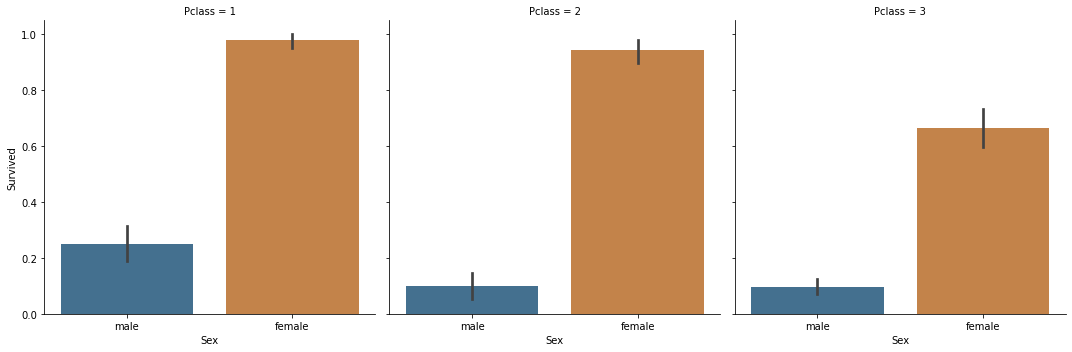

In [30]:
sns.catplot(data = df,y='Survived',x='Sex',col='Pclass',
            kind='bar', saturation=0.5)

Во всех классах женщины спаслись больше мужчин, это говорит о героизме мужчин на борту, так как мы ранее узнали, что их было значительно больше, а также наблюдаем, что пассажиров первого класса спаслось больше( проверим это далее)

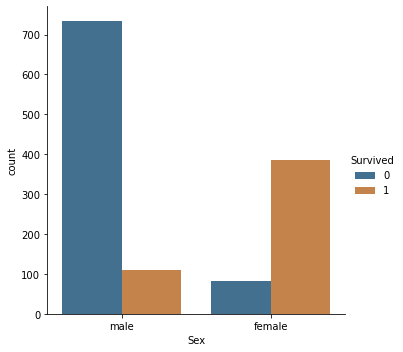

In [31]:
sns.catplot(data = df,hue = 'Survived', x = 'Sex',
            kind='count', saturation=0.5)

На этом графике хорошо видно соотношение выживших мужчин и женщин после крушения. Предположим, что люди 'богатый' сегмент спасались чаще чем остальные.

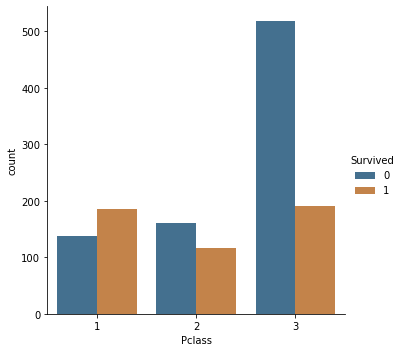

In [32]:
sns.catplot(data = df,hue = 'Survived', x = 'Pclass',
            kind='count', saturation=0.5)

Подтверждаем гипотизу, большинство погибших- это пассажиры третьего класса, а наименьшее число гиблей и наибольшее выживших мы наблюдаем в первом классе. Ранее мы уже изучили, что большинство пассажиров в третьем классе- это мужчины. Можно уловить связь - вероятность погибнуть у мужчины в третьем классе больше, чем вероятность погибнуть у всех остальных пассажиров. Соотношение погибших-выживших во втором классе примерно одинаковое. 

Возможно, дети выживали реже взрослых, в связи с невозможностью дееспособности.Поделим возраст на 7 перцентилей.

<AxesSubplot:>

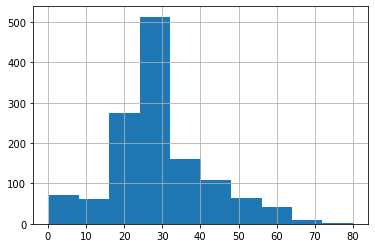

In [33]:
df.Age.hist()

Из распределения, видно, что людей 30 лет погибло больше остальных, но и среднее у нас в этом значении. Разобьем всех на 7 групп с помощью категоризации.

(<seaborn.axisgrid.FacetGrid at 0x205fc3285e0>,
 (array([0, 1, 2, 3, 4, 5, 6]),
  [Text(0, 0, '(0.169, 18.0]'),
   Text(1, 0, '(18.0, 24.0]'),
   Text(2, 0, '(24.0, 29.0]'),
   Text(3, 0, '(29.0, 29.881]'),
   Text(4, 0, '(29.881, 33.0]'),
   Text(5, 0, '(33.0, 43.0]'),
   Text(6, 0, '(43.0, 80.0]')]))

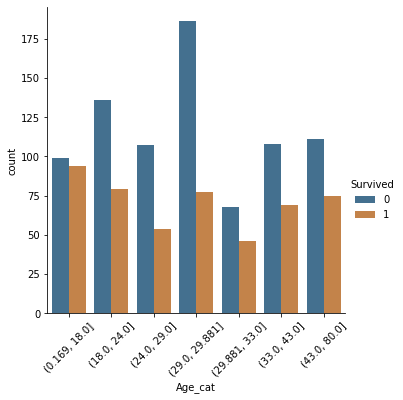

In [34]:
df['Age_cat'] = pd.qcut(df.Age,7)
sns.catplot(data = df,hue = 'Survived', x = 'Age_cat',
            kind='count', saturation=0.5), plt.xticks(rotation=45)

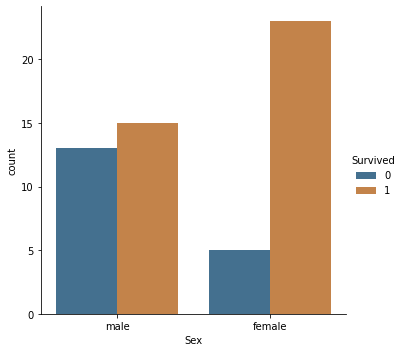

In [35]:
child= df[df.Age<6]
sns.catplot(data = child,hue = 'Survived', 
            x = 'Sex',kind='count', saturation=0.5)

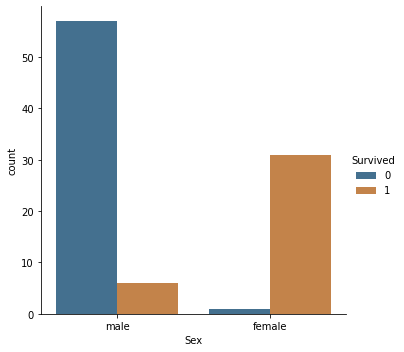

In [36]:
grand= df[df.Age>50]
sns.catplot(data = grand,hue = 'Survived', 
            x = 'Sex',kind='count', saturation=0.5)

В целом на корабле предпочли спасать женщин и детей в первую очередь. Зависимости от возраста наблюдается. Например, погибнуть у мужчины за 50 шансов было больше. Проверим как влиял размер сеиьи на выживаемость. Ранее на графике наблюдалось аномальное количество погибших в 29 лет, (конечно, мы меняли пропуски на среднее, и медиана находится примерно здесь)

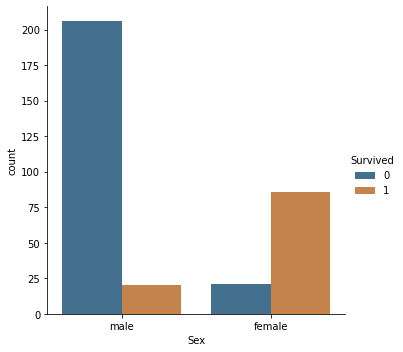

In [37]:
h = df[(df.Age>=29)&(df.Age<=30)]
sns.catplot(data = h,hue = 'Survived',
            x = 'Sex',kind='count', saturation=0.5)

Опять же, высокий бар дали мужчины. Проверим как наличие семьи на борту повлияло на выживаемость.

In [38]:
df = df.drop('Age_cat', axis=1)
df['family'] = df['Parch'] + df['SibSp']

Обычно мы можем добавлять новые наблюдения, с помощью арифметических операций ( как в ячейке выше). Такая переменная будет отражать на общее количество человек семьи на борту.

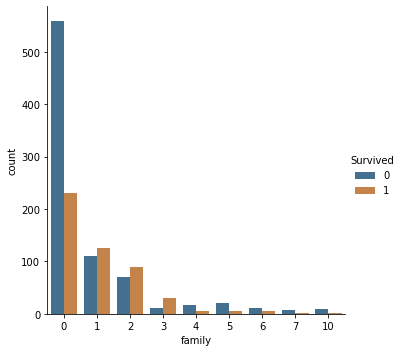

In [39]:
sns.catplot(data = df,hue = 'Survived', x = 'family',
            kind='count', saturation=0.5)

Мы наблюдаем некую форму графика, а это означает, что у вычисленной переменной есть хорошее влияние на выживаемость. Такую переменную необходимо оставить для увеличения предсказательной способности.

Чем меньше семья- тем больше шансов выжить.

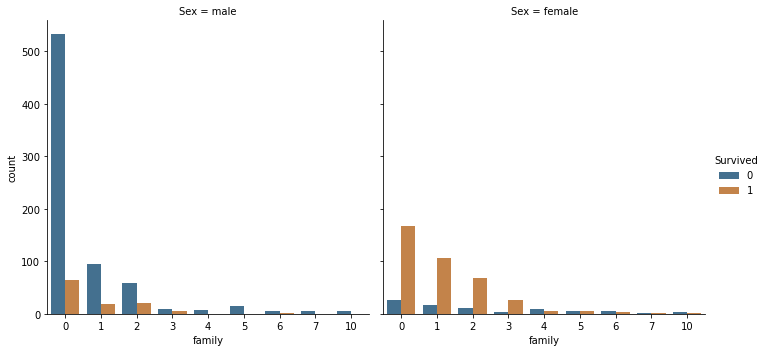

In [40]:
sns.catplot(data = df,hue = 'Survived', x = 'family',
            col = 'Sex',kind='count', saturation=0.5)

Дополнительно можно посмотреть как размер семьи повлиял на выживаемость внутри гендерных групп.

### Модель "Baseline" на основе логических выводов

In [41]:
df['result'] = 1
df.loc[(df.Sex == 'male')&(df.Pclass == 3), 'result'] = 0
df.loc[(df.Sex == 'male')&(df.Age > 50), 'result'] = 0
df.loc[df['family']>3, 'result'] = 0

Здесь я присвоила "смерть" всем мужчинам в третьем классе, всем мужчинам старше 50, всем семьям, в которых больше 3 человек. Теперь оценим точность.

In [42]:
df['errors'] = (df.Survived - df.result)**2
1 - df.errors.sum() / df.shape[0]

0.7203972498090145

Отличный результат для моделей такого типа, в 72 случаях из 100 мы правильно предсказываем событие, а это гораздо выше случайности. Попробуем добавить еще один критерий

In [43]:
df.loc[(df.Sex == 'male')&(df.Age >=29)&(df.Age <=39), 'result'] = 0
df['errors'] = (df.Survived - df.result)**2
1 - df.errors.sum() / df.shape[0]

0.7815126050420168

Предсказательный вектор улучшил точность до 78,9%! Тут мы предсказывали смерти, что если мы попробуем предсказать спасение?

In [44]:
df['alive'] = 0
df.loc[(df.Sex == 'female')&((df.Pclass == 1)&
                             (df.Pclass == 2)), 'alive'] = 1
df.loc[df.Age < 6, 'alive'] = 1
df.loc[(df.Sex == 'female')&
       (df['family'] < 2), 'alive'] = 1
df.loc[(df.Sex == 'male')& (df['family'] < 2)&
       (df.Pclass == 1), 'alive'] = 1

In [45]:
df['errors_2'] = (df.Survived - df.alive)**2
1 - df.errors_2.sum() / df.shape[0]

0.7524828113063406

В коде выше мы спасли всех женщин 1-2 класса, детей младше 6 лет, женщин у кого семья меньше 2 человек и мужчин в первом классе с семьей меньше двух.

Полученная точность наглядно показывает, если хорошо познакомиться и изучить данные можно вывести гипотезы, которые помогут реализовать правило предсказания, основываясь на одних лишь логических выводах.